# RPMI Railpen Case Study

The data is an example of the type of signal we compute within the ARP team. Our investment universe is defined by a benchmark made of about 2500 stocks. We are interested in ranking those stocks based on some criteria; this is called cross sectional ranking. 

The idea is then to invest in the top stocks based on that ranking. For instance, a ‘Price Momentum’ factor would rank all the stocks at a given date based on their past performance, clearly identifying the best and worst performers.
 
You will find, in the attached file, 2 of the factors that we compute every month for all the stocks within our investment universe. 

- Each stock is represented by an identifier called  ‘TradingItemID’. 
- The first factor is based on ‘Value’ metrics (such as ‘Earnings Yield’, ‘Book-to-Price’), 
- whilst the other is made of ‘Quality’ metrics (such as ‘Return-on-Equity’ or ‘Return-on-Assets’).
 
The objective of this case study is to come up with a way to visualise and understand the relationship between the 2 factors. It is intentionally a bit vague to allow you as much freedom as possible to demonstrate how you work with datasets and develop tools to help to understand the data and identify relationships within it.
 
Additionally, please familiarise yourself with the dataset as we will ask more specific questions about the interaction between those two factors during the interview (such as what the factor values could represent).

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

#### Import Data

In [2]:
data=pd.read_csv('data/factorextract.csv', encoding="ISO-8859-1")
data.head()

,companyname,datadate,tradingitemid,Factor_VALUE,Factor_QUALITY
0,Aflac Incorporated,31/12/2015,2586086,0.549291,0.326100
1,AGCO Corporation,31/12/2015,2586108,0.526177,-0.952003
2,Southern Company Gas,31/12/2015,2586118,0.238246,-0.509698
3,The AES Corporation,31/12/2015,2586130,0.573466,-1.174225
4,Time Warner Inc.,31/12/2015,2586256,0.226773,0.079849


#### Type Check & Convert

In [3]:
data['tradingitemid'] = data['tradingitemid'].apply(str)
data['date'] = pd.to_datetime(data['datadate'])
data.dtypes

companyname               object
datadate                  object
tradingitemid             object
Factor_VALUE             float64
Factor_QUALITY           float64
date              datetime64[ns]
dtype: object

#### Create a Security Master
Given that there are multiple names for a `tradingitemid` key, we will create a table to store the mapping so that we can display one consistent version of the name. We assign a default display name for each company based on the the first encountered entry.

In [4]:
print(f'{len(data.companyname.unique())} unique company names')
print(f'{len(data.tradingitemid.unique())} unique trading item ids')
securities = data.groupby('tradingitemid').agg({'companyname': ['unique','nunique']})
securities.columns = ["_".join(x) for x in securities.columns.ravel()]
# default to first item if there is more than one company name
securities['display_name'] = securities['companyname_unique'].apply(lambda x: x[0])
securities[securities['companyname_nunique'] > 1].head()

3106 unique company names
2698 unique trading item ids


,companyname_unique,companyname_nunique,display_name
tradingitemid,,,
104932249,"[AO Smith Corp., A. O. Smith Corporation]",2,AO Smith Corp.
108097646,"[Tauron Polska Energia Spolka Akcyjna, TAURON ...",2,Tauron Polska Energia Spolka Akcyjna
108803915,"[Tesla Motors, Inc., Tesla, Inc.]",2,"Tesla Motors, Inc."
111574674,"[NXP Semiconductors NV, NXP Semiconductors N.V.]",2,NXP Semiconductors NV
113349069,"[China Medical System Holdings Ltd., China Med...",2,China Medical System Holdings Ltd.


#### Quantify Missing Values & Records

In [5]:
missing_value = data[data['Factor_VALUE'].isna()]
missing_quality = data[data['Factor_QUALITY'].isna()]
print(f'{len(missing_value)} values for field Factor_VALUE are missing')
print(f'{len(missing_quality)} values for field Factor_QUALITY are missing')

all_dates = data.date.unique()
date_count = len(all_dates)

grouped = (
    data
    .groupby('tradingitemid')
    .agg({'date': ['min', 'max', 'count', 'unique']})
)
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
data_point_threshold = 6
stocks_with_insufficient_data = grouped[grouped['date_count'] < data_point_threshold]
print(f'{len(stocks_with_insufficient_data)} stocks with less than {data_point_threshold} monthly data points')
stocks_with_insufficient_data.head()

7 values for field Factor_VALUE are missing
9 values for field Factor_QUALITY are missing
314 stocks with less than 6 monthly data points


,date_min,date_max,date_count,date_unique
tradingitemid,,,,
100058479,2015-12-31,2016-01-31,2,"[2015-12-31T00:00:00.000000000, 2016-01-31T00:..."
106521423,2016-09-30,2016-12-31,4,"[2016-09-30T00:00:00.000000000, 2016-10-31T00:..."
114215334,2015-12-31,2016-01-31,2,"[2015-12-31T00:00:00.000000000, 2016-01-31T00:..."
114870735,2015-12-31,2016-04-30,5,"[2015-12-31T00:00:00.000000000, 2016-01-31T00:..."
115024345,2015-12-31,2016-01-31,2,"[2015-12-31T00:00:00.000000000, 2016-01-31T00:..."


#### Remove Unqualified Records
we remove records with no values and stocks where there is insufficient data histories (6 months or less)

In [6]:
# Act on missing values - drop them
print(f'before {len(data)} records')
data.dropna(inplace=True)
print(f'after  {len(data)} records')

before 30880 records
after  30864 records


In [7]:
# Act on stocks with insufficient data points - accept only stocks with 6 months data or more
print(f'before {len(data)} records')
data = data[~data['tradingitemid'].isin(stocks_with_insufficient_data.index)]
print(f'after  {len(data)} records')

before 30864 records
after  30043 records


#### Detect and Filter Outliers

In [8]:
data.describe()

,Factor_VALUE,Factor_QUALITY
count,30043.000000,30043.000000
mean,0.250747,0.008206
std,46.164955,0.965732
min,-6.287469,-4.968624
25%,-0.389319,-0.443216
50%,0.154875,-0.046451
75%,0.549471,0.451419
max,8000.000000,4.906565


We can see that `Factor_VALUE` has some outliers since std dev is quite high.
We remove any records with std dev of 3 or more.

In [9]:
print(f'before {len(data)} records')
data = data[np.abs(data.Factor_VALUE-data.Factor_VALUE.mean())<=(3*data.Factor_VALUE.std())]
print(f'after  {len(data)} records')
data.describe()

before 30043 records
after  30042 records


,Factor_VALUE,Factor_QUALITY
count,30042.000000,30042.000000
mean,-0.015539,0.008217
std,0.956481,0.965746
min,-6.287469,-4.968624
25%,-0.389322,-0.443267
50%,0.154866,-0.046418
75%,0.549342,0.451458
max,6.179276,4.906565


#### Aggregate for cross-section comparison

In [10]:
# Rate of Change measure as a naive proxy of momentum
def roc(series):
    if len(series) < 1:
        return 0
    first = series.values[0]
    last = series.values[-1]
    return (last-first)/first

In [11]:
agg_data = (
    data
    .groupby('tradingitemid')
    .agg({
        'Factor_QUALITY':{ 
            'mean':'mean',
            'roc' : lambda x: roc(x)
        },
        'Factor_VALUE':{ 
            'mean':'mean',
            'roc' : lambda x: roc(x)
        },
        'tradingitemid': ['count']
    })
)
agg_data.columns = ['_'.join(x) for x in agg_data.columns.ravel()]
agg_data = agg_data.join(securities['display_name'])
agg_data.head()

/Users/hanwei/RPMI/Test/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Factor_QUALITY_mean,Factor_QUALITY_roc,Factor_VALUE_mean,Factor_VALUE_roc,tradingitemid_count,display_name
tradingitemid,,,,,,
100131882,0.384720,-0.647526,0.081240,-0.346345,13,Brenntag AG
100324016,0.364454,0.913461,0.810287,0.208776,13,"Dai-ichi Life Holdings, Inc."
100667466,0.346180,1.772812,0.688413,-0.047282,13,General Motors Company
10090310,-3.446212,0.959471,0.905470,-0.572369,13,"Alnylam Pharmaceuticals, Inc."
10286451,0.394272,-0.556837,0.002503,-1.133538,13,"CBRE Group, Inc."


#### Rankings
The rankings are naive summations with equal weigths consisting of Quality, Value and their momentums

In [12]:
Quality_weight = 1
Value_weight = 1
Quality_roc_weight = 1
Value_roc_weight = 1

agg_data['Rank'] = (
    (
        agg_data['Factor_QUALITY_mean'] * Quality_weight
        + agg_data['Factor_VALUE_mean'] * Value_weight
        + agg_data['Factor_QUALITY_roc'] * Quality_roc_weight
        + agg_data['Factor_VALUE_roc'] * Value_roc_weight
    )
    .astype(float)
    .rank(method='dense', ascending=False)
    .astype(int)
)
agg_data.rename(columns={'display_name':'Stock'}, inplace=True)
agg_data.rename(columns={'Factor_QUALITY_mean':'Quality'}, inplace=True)
agg_data.rename(columns={'Factor_VALUE_mean':'Value'}, inplace=True)
agg_data.rename(columns={'Factor_QUALITY_roc':'Q_roc'}, inplace=True)
agg_data.rename(columns={'Factor_VALUE_roc':'V_roc'}, inplace=True)

In [13]:
# Top 10
rankings = agg_data.sort_values('Rank', ascending=True)[['Stock','Rank','Quality','Value','Q_roc','V_roc']]
top10 = rankings.head(10)
top10

,Stock,Rank,Quality,Value,Q_roc,V_roc
tradingitemid,,,,,,
112760461,CJ E&M Corporation,1,-0.498687,0.673892,0.380701,553.450857
20184020,Randstad Holding NV,2,0.751370,0.266122,0.237753,447.787556
20130957,Ashtead Group plc,3,1.355683,-0.025480,-0.352370,236.576413
317560689,Willis Towers Watson Public Limited Company,4,0.534415,-0.263847,234.997624,1.276044
20173501,GKN plc,5,0.570308,0.072719,3.340625,226.536256
2617773,"The Hartford Financial Services Group, Inc.",6,-0.246838,0.593692,192.256566,0.044787
52984459,Mead Johnson Nutrition Company,7,2.332981,1.701770,88.559356,-1.588996
2617677,"Harley-Davidson, Inc.",8,-0.200146,-0.142465,81.994031,-8.374797
20215843,Wipro Ltd.,9,0.576033,0.116535,-0.238246,70.599270


In [17]:
# Bottom 10
bottom10 = rankings.tail(10)
bottom10

,Stock,Rank,Quality,Value,Q_roc,V_roc
tradingitemid,,,,,,
2629738,"Merck & Co., Inc.",2375,-0.146993,-0.346866,0.844638,-78.613632
2588568,"Amazon.com, Inc.",2376,0.664001,-3.824028,-83.241102,-0.189508
31781269,"Murata Manufacturing Co., Ltd.",2377,0.720980,0.243825,-0.093560,-88.116531
20158713,ITOCHU Techno-Solutions Corporation,2378,-0.059513,0.437676,-98.546041,0.154677
20243334,Groupe Bruxelles Lambert SA,2379,-0.549169,0.421881,-105.578270,-1.306518
33609199,Global Telecom Holding S.A.E.,2380,-1.957628,-0.227677,-0.076873,-148.861213
20185089,Ayala Corp.,2381,-0.123730,0.069379,-0.537273,-240.257269
2660877,"United Parcel Service, Inc.",2382,0.615681,-0.114304,-539.615422,176.281111
20216624,Oil Search Limited,2383,-1.637201,0.375263,-935.812614,-1.489473


### Visualise the Relationships

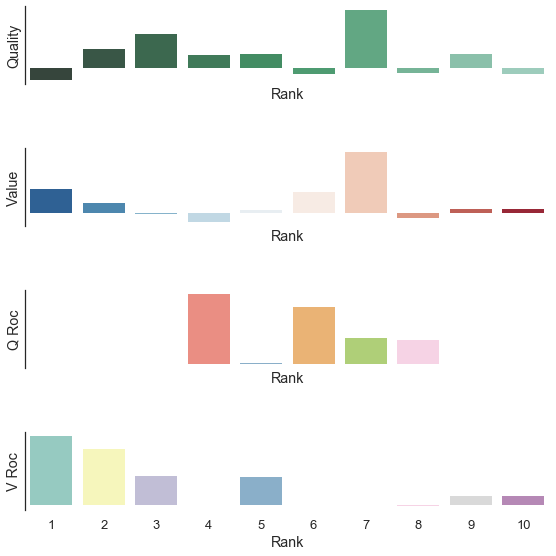

In [15]:
sns.set(style="white", context="talk")
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

x = top10['Rank']
y1 = top10['Quality']
sns.barplot(x, y1, palette="BuGn_d", ax=ax1)
ax1.set_ylabel("Quality")

y2 = top10['Value']
sns.barplot(x, y2, palette="RdBu_r", ax=ax2)
ax2.set_ylabel("Value")

y3 = top10['Q_roc']
sns.barplot(x, y3, palette="Set3", ax=ax3)
ax3.set_ylabel("Q Roc")

y4 = top10['V_roc']
sns.barplot(x, y4, palette="Set3", ax=ax4)
ax4.set_ylabel("V Roc")

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=3)

#### Cross-section Scatter Plot month-by-month
This gives us an overview of how the data changes over time. There is a simple regression line calculated to allow us to spot any changes in the way the data evolves

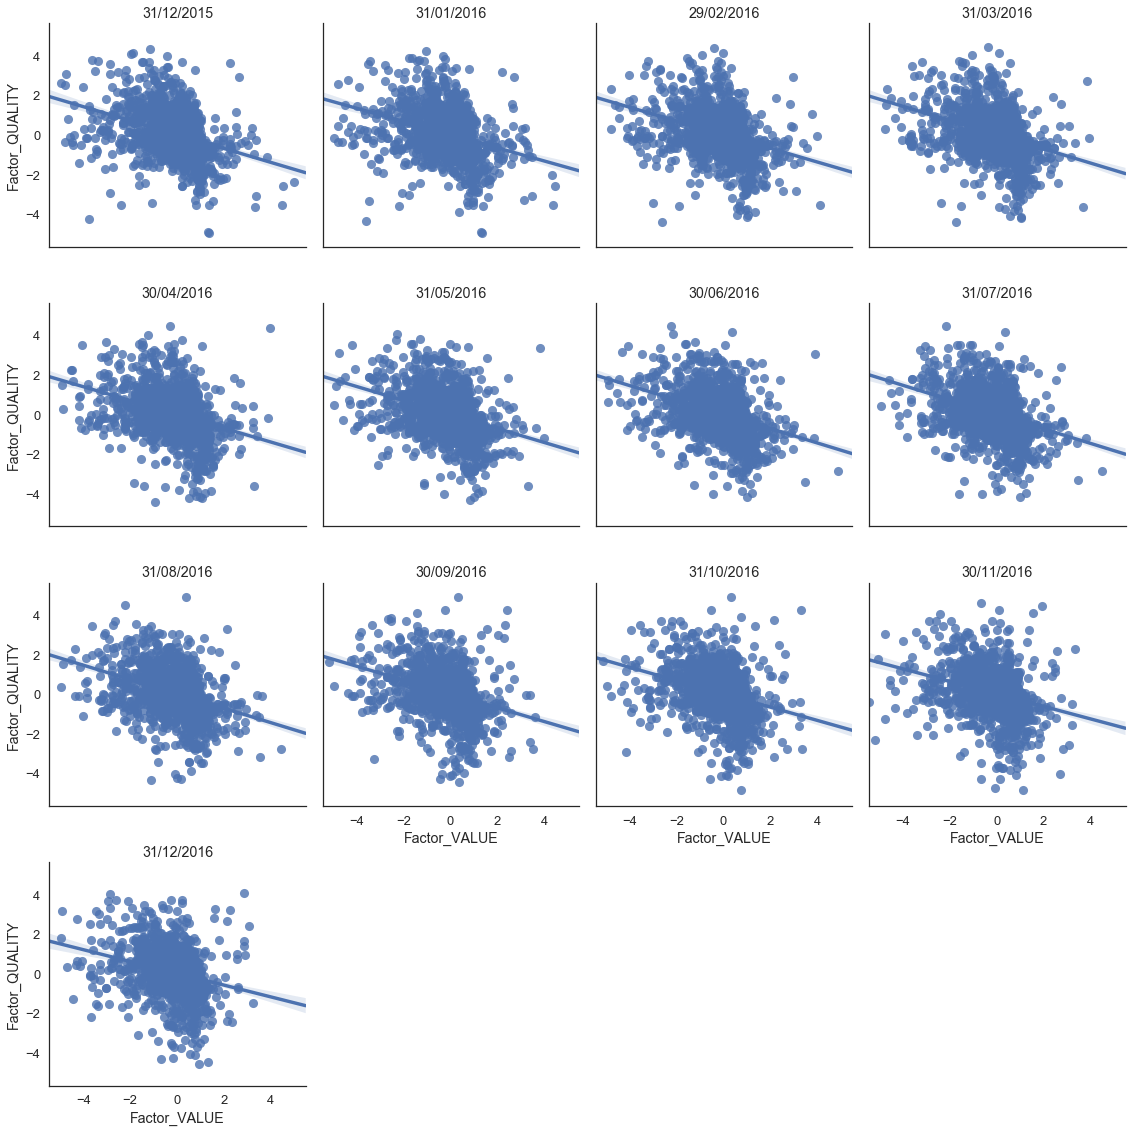

In [16]:
g = sns.FacetGrid(data, col="datadate", col_wrap=4, size=4)
g.map(sns.regplot, "Factor_VALUE", "Factor_QUALITY")
g.set_titles('{col_name}')